# fit_preisach.ipynb
The purpose of this notebook is to estimate an optimal Preisach density for the purpose of matching hysteresis curves with an analogous Jiles-Atherton model.

In [1]:
from numpy import array, meshgrid
from scipy.optimize import minimize
from scipy.ndimage import zoom
from matplotlib import pyplot as plt
from hysteresis_models import jiles_atherton, preisach
from density_functions import gaussian
plt.ion()

In [2]:
# Define magnetizing field parameters for both models
Hlim = 4e3
dH = 10

# Define a grid of alpha/beta values & a grid density for the Preisach model
nGrid = 1000
preisach_grid = -1+2*array([[a,b] for a in range(nGrid) for b in range(nGrid)])/nGrid
preisach_density = gaussian(preisach_grid, array([.5,-.5]), array([[.06,-.03],[-.03,.06]]))

# Set model parameters for grade 20 steel
ja_params = {
     'alpha': 4.93e-4,
     'a': 399,
     'Ms': 1.35e6,
     'k': 300,
     'c': 0.120,
     'wa': 0,
     'Ka': 0,
     'psi': 0,
}
pr_params = {
    'Ms': 1.2e6,
    'grid': Hlim*preisach_grid,
    'density': preisach_density,
}

# You can also easily load model parameter dictionaries using pickle:
# ja_params = pickle.load("Models/g20steel_ja.pickle")
# pr_params = pickle.load("Models/g20steel_pr.pickle")

# Set hysteresis calculation options
ja_opts = {
    'integrator': 'EULER',
    'H_lim': Hlim,
    'dH': 10,
}
pr_opts = {
    'H_lim': 4e3,
    'dH': 10,
}

# Construct a Jiles-Atherton model & compute its hysteresis
jaModel = jiles_atherton(**ja_params)
jaH, jaB = jaModel.get_hysteresis(**ja_opts)

# Construct a Preisach model & compute its hysteresis
prModel = preisach(**pr_params)
prH, prB = prModel.get_hysteresis(**pr_opts)
prErr = prB-jaB[int(Hlim/dH):][::-1]
prRMSE = ((prErr@prErr)/len(prErr))**.5

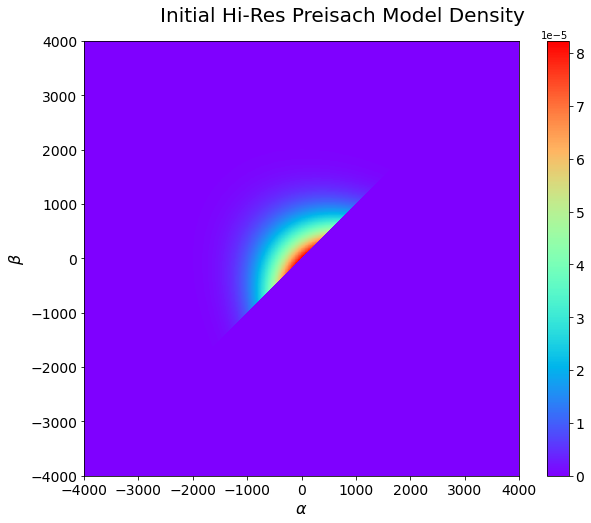

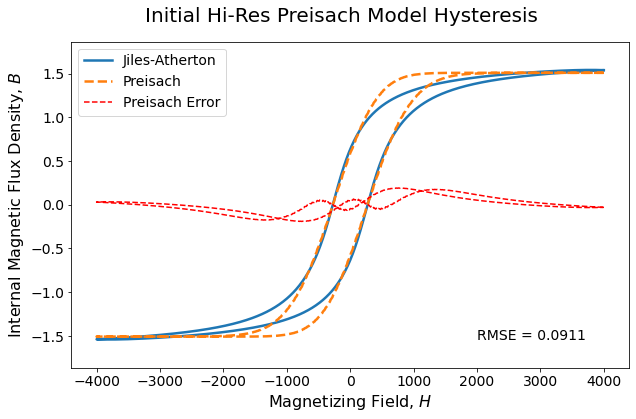

In [30]:
# Define keyword arguments for all density image plots
imKwargs = {
    'origin':'lower',
    'cmap':'rainbow',
    'interpolation':'none',
    'extent':[-Hlim,Hlim,-Hlim,Hlim],
}

# Plot the initial proposed lo-res Preisach density
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle(r"Initial Hi-Res Preisach Model Density", fontsize=20, y=.94)
im = ax.imshow(preisach_density.reshape(nGrid,nGrid).T, **imKwargs)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r"$\alpha$",fontsize=16)
ax.set_ylabel(r"$\beta$",fontsize=16)
ax.tick_params(labelsize=14)
fig.show()

# Plot hysteresis curves for both models
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"Initial Hi-Res Preisach Model Hysteresis",fontsize=20,y=.96)
ax.plot(jaH[int(Hlim/dH):],jaB[int(Hlim/dH):],lw=2.5,label=r"Jiles-Atherton")
ax.plot(prH,prB,lw=2.5,label=r"Preisach",ls='--')
ax.plot(prH,prErr,'r--',label=r"Preisach Error")
ax.legend(fontsize=14)
ax.axis(1.1*array([-ja_opts['H_lim'],ja_opts['H_lim'],1.1*jaB.min(),1.1*jaB.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=16)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=16)
ax.text(.5*Hlim,jaB.min(),r"RMSE = %.4f"%prRMSE,fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

In [4]:
# For ease of use, define the 
jaHFit = jaH[int(Hlim/dH):][::-1]
jaBFit = jaB[int(Hlim/dH):][::-1]

# Define a grid of alpha/beta values & an initial proposed density for the Preisach model
nGFit = 100
prFit_grid = -1+2*array([[a,b] for a in range(nGFit) for b in range(nGFit)])/nGFit
prProp_density = gaussian(prFit_grid, array([.5,-.5]), array([[.06,-.03],[-.03,.06]]))

# Construct the initial proposed Preisach model & compute its hysteresis for demonstration
prInit_params = {
    'Ms': 1.2e6,
    'grid': Hlim*prFit_grid,
    'density': prProp_density,
}
prInitModel = preisach(**prInit_params)
prH0, prB0 = prInitModel.get_hysteresis(**pr_opts)
prE0 = prB0-jaBFit
prRMSE0 = ((prE0@prE0)/len(prE0))**.5

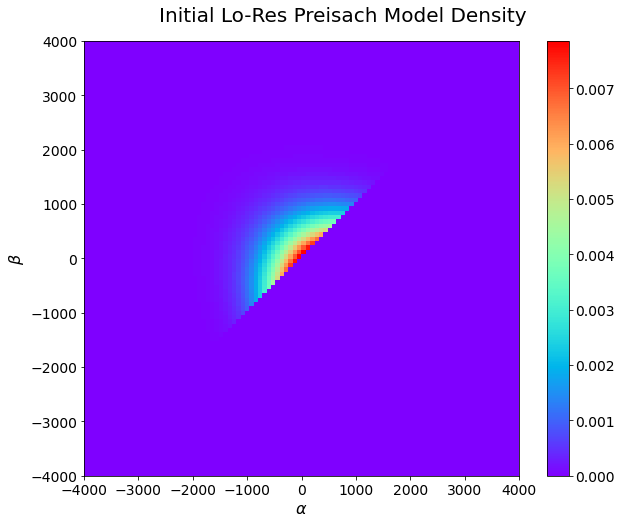

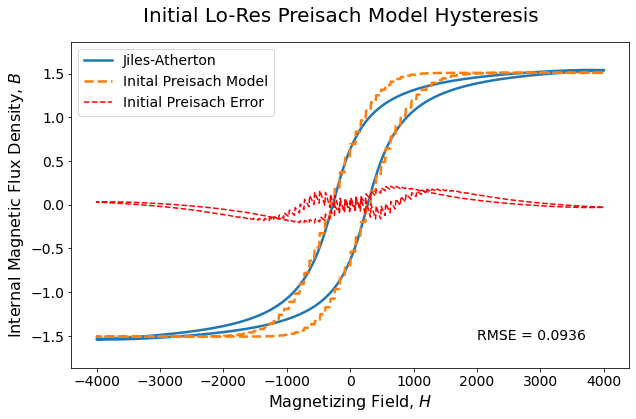

In [31]:
# Plot the initial proposed lo-res Preisach density
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle(r"Initial Lo-Res Preisach Model Density", fontsize=20, y=.94)
im = ax.imshow(prProp_density.reshape(nGFit,nGFit).T, **imKwargs)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r"$\alpha$",fontsize=16)
ax.set_ylabel(r"$\beta$",fontsize=16)
ax.tick_params(labelsize=14)
fig.show()

# Plot hysteresis curve for initial lo-res model
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"Initial Lo-Res Preisach Model Hysteresis",fontsize=20,y=.96)
ax.plot(jaHFit,jaBFit,lw=2.5,label=r"Jiles-Atherton")
ax.plot(prH0,prB0,lw=2.5,label=r"Inital Preisach Model",ls='--')
ax.plot(prH0,prE0,'r--',label=r"Initial Preisach Error")
ax.legend(fontsize=14)
ax.axis(1.1*array([-ja_opts['H_lim'],ja_opts['H_lim'],1.1*jaBFit.min(),1.1*jaBFit.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=16)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=16)
ax.text(.5*Hlim,jaBFit.min(),r"RMSE = %.4f"%prRMSE0,fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

In [6]:
# Returns the loss (here, RMSE) of a proposal Preisach density relative to a known hysteresis curve
def fit_loss(prDensity, H_true, B_True):
    prop_params = {
        'Ms': prInit_params['Ms'],
        'grid': prInit_params['grid'],
        'density': prDensity
    }
    prProp = preisach(**prop_params)
    propH, propB = prProp.get_hysteresis(**pr_opts)
    err = propB-B_True
    return ((err@err)/len(err))**.5

# Define bounds for density values
param_bounds = array([[0,1] for i in range(len(prProp_density))])
min_opts = {
    'disp': True,
    'ftol': 1e-3,
    'gtol': 1e-6,
    'maxfun': 1e6,
    'maxiter': 1e6,
}
opt_out = minimize(fit_loss, prProp_density, args=(jaHFit, jaBFit, ), bounds=param_bounds, options=min_opts)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0      5050 variables are exactly at the bounds

At iterate    0    f=  9.35592D-02    |proj g|=  9.19719D-01

At iterate    1    f=  7.13892D-02    |proj g|=  2.32781D-01

At iterate    2    f=  5.90482D-02    |proj g|=  3.90706D-01

At iterate    3    f=  4.93775D-02    |proj g|=  4.38778D-01

At iterate    4    f=  4.38520D-02    |proj g|=  1.63384D-01

At iterate    5    f=  4.27346D-02    |proj g|=  1.61047D-01

At iterate    6    f=  3.77369D-02    |proj g|=  1.61731D-01

At iterate    7    f=  3.45592D-02    |proj g|=  1.81753D-01

At iterate    8    f=  3.17932D-02    |proj g|=  1.97340D-01

At iterate    9    f=  3.05052D-02    |proj g|=  1.96003D-01

At iterate   10    f=  2.87976D-02    |proj g|=  1.77606D-01

At iterate   11    f=  2.72913D-02    |proj g|=  1.54452D-01

At iterate   12    f=  2.51730D-02    |proj g|=  1.18278D-01

At iterate   13    f=  2.3

In [7]:
# Build a Preisach model using the optimized parameters
opt_density = opt_out.x
opt_params = {
    'Ms': prInit_params['Ms'],
    'grid': prInit_params['grid'],
    'density': opt_density
}
optModel = preisach(**opt_params)
optH, optB = optModel.get_hysteresis(**pr_opts)
optErr = optB-jaBFit
optRMSE = ((optErr@optErr)/len(optErr))**.5

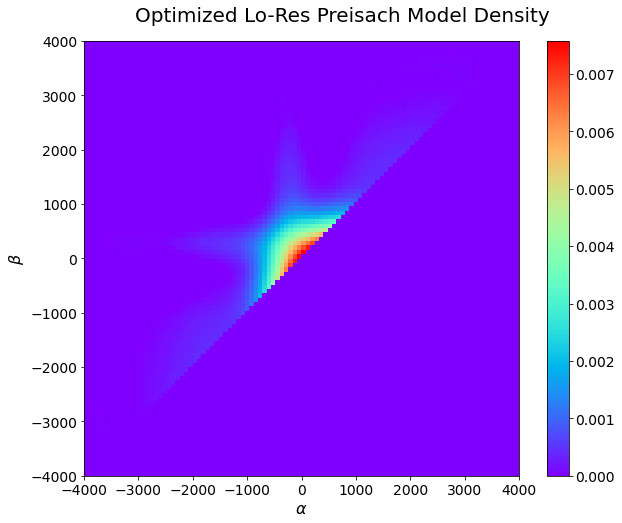

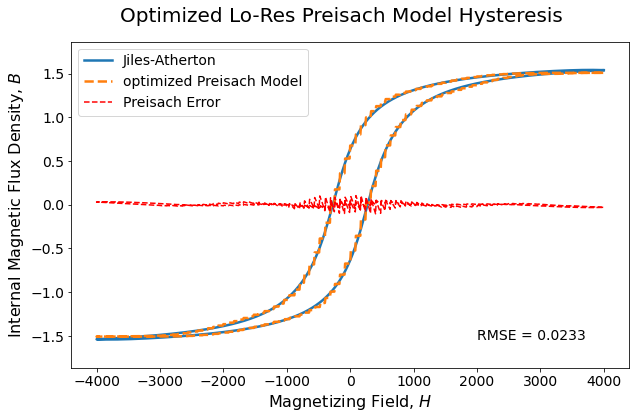

In [32]:
# Plot the optimized lo-res Preisach density
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle(r"Optimized Lo-Res Preisach Model Density", fontsize=20, y=.94)
im = ax.imshow(opt_density.reshape(nGFit,nGFit).T, **imKwargs)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r"$\alpha$",fontsize=16)
ax.set_ylabel(r"$\beta$",fontsize=16)
ax.tick_params(labelsize=14)
fig.show()

# Plot hysteresis curve for the optimized lo-res model
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"Optimized Lo-Res Preisach Model Hysteresis",fontsize=20,y=.96)
ax.plot(jaHFit,jaBFit,lw=2.5,label=r"Jiles-Atherton")
ax.plot(optH,optB,lw=2.5,label=r"optimized Preisach Model",ls='--')
ax.plot(optH,optErr,'r--',label=r"Preisach Error")
ax.legend(fontsize=14)
ax.axis(1.1*array([-ja_opts['H_lim'],ja_opts['H_lim'],1.1*jaBFit.min(),1.1*jaBFit.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=16)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=16)
ax.text(.5*Hlim,jaBFit.min(),r"RMSE = %.4f"%optRMSE,fontsize=14)
ax.tick_params(labelsize=14)
plt.show()

In [9]:
# Interpolate the lo-res density 
hires_density = zoom((opt_density+opt_density.T).reshape(nGFit,nGFit),int(nGrid/nGFit),mode='nearest').reshape(nGrid**2)
hires_density[hires_density<=.01*hires_density.max()] = 0
hires_density[preisach_grid[:,0]>=preisach_grid[:,1]] = 0
hires_density /= hires_density.sum()


In [10]:
# Build a Preisach model using the optimized parameters on a hi-res grid
hires_params = {
    'Ms': prInit_params['Ms'],
    'grid': preisach_grid,
    'density': hires_density,
}
hiresModel = preisach(**hires_params)
hiresH, hiresB = hiresModel.get_hysteresis(**pr_opts)
hiresErr = hiresB-jaBFit
hiresRMSE = ((hiresErr@hiresErr)/len(hiresErr))**.5

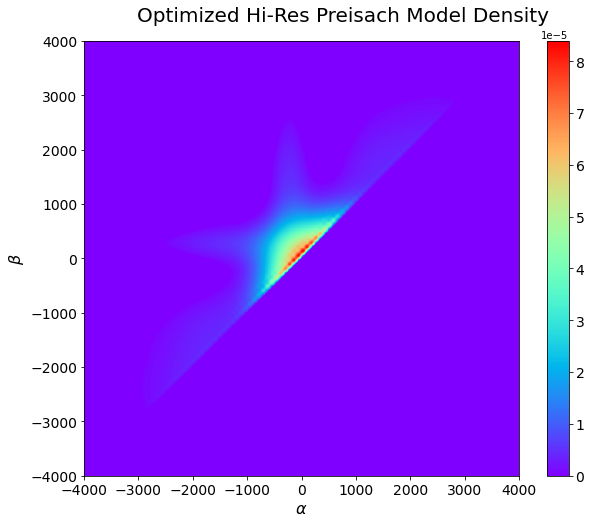

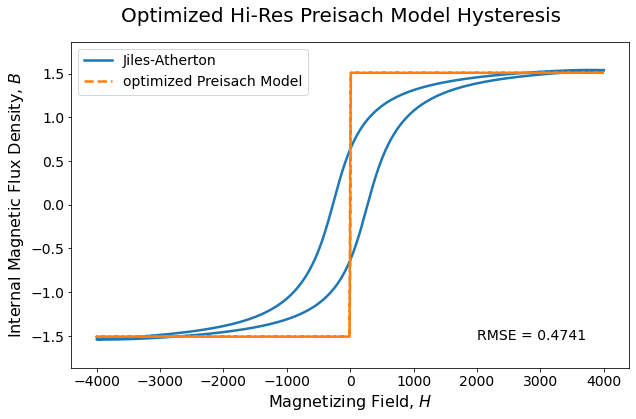

In [33]:
# Plot the optimized lo-res Preisach density
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle(r"Optimized Hi-Res Preisach Model Density", fontsize=20, y=.94)
im = ax.imshow(hires_density.reshape(nGrid,nGrid).T, **imKwargs)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r"$\alpha$",fontsize=16)
ax.set_ylabel(r"$\beta$",fontsize=16)
ax.tick_params(labelsize=14)
fig.show()

# Plot hysteresis curve for the optimized hi-res model
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"Optimized Hi-Res Preisach Model Hysteresis",fontsize=20,y=.96)
ax.plot(jaHFit,jaBFit,lw=2.5,label=r"Jiles-Atherton")
ax.plot(hiresH,hiresB,lw=2.5,label=r"optimized Preisach Model",ls='--')
#ax.plot(hiresH,hiresErr,'r--',label=r"Preisach Error")
ax.legend(fontsize=14)
ax.axis(1.1*array([-ja_opts['H_lim'],ja_opts['H_lim'],1.1*jaBFit.min(),1.1*jaBFit.max()]))
ax.set_xlabel(r"Magnetizing Field, $H$",fontsize=16)
ax.set_ylabel(r"Internal Magnetic Flux Density, $B$",fontsize=16)
ax.text(.5*Hlim,jaBFit.min(),r"RMSE = %.4f"%hiresRMSE,fontsize=14)
ax.tick_params(labelsize=14)
plt.show()